In [32]:
import quantecon as qe
import numpy as np
import scipy
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
from scipy import optimize
from scipy.interpolate import interp1d

### Endogenous Grid Method

Problem:

#### Standard VFI Form:

$$V_{n+1}(k_i , z_j) = \max_{k'} \left\{\dfrac{(z_jk_i^\alpha + (1-\delta)k_i - k')^{1-\gamma}}{1-\gamma} + \beta \mathbb{E}( V_n(k',z') | z_j)\right\}$$
$$\text{s.t. } k' \geq k_{min}$$
$$ln(z') = \rho ln(z) + \eta'$$

#### EGM Form:

$$V_{n+1}(k , z_j) = \max_{k_i'} \left\{\dfrac{(z_jk^\alpha + (1-\delta)k - k_i')^{1-\gamma}}{1-\gamma} + \beta \mathbb{E}( V_n(k_i',z') | z_j)\right\}$$
$$\text{s.t. } ln(z') = \rho ln(z) + \eta'$$

So in the EGM form, we are creating grid for:
- capital grid for tomorrow's values
- Today's states

To understand why this method is better than standard VFI, we need to look at the FOC that we have to solve in standard VFI and compare it the FOC of EGM:

- Standard VFI: $(z_jk_i^\alpha + (1-\delta)k_i - k')^{-\gamma} = \beta \mathbb{E}(V_k(k',z')|z_j)$

- EGM: $z_k k^\alpha + (1-\delta)k = [\beta \mathbb{E}(V_k(k_i',z')|z_j)]^{\frac{-1}{\gamma}}+ k_i'$ 

Yes, even in EGM we need to solve for k (and it is a non-linear equation) but it is much easier to solve the first one for k' because we don't need to interpolate $\mathbb{E}(V_k(k',z')|z_j)$ for each off grid k' because all the k' s are on the grid (we chose the tomorrow's capital grid). Another beautiful thing is that instead of constantly evaluating expected value for tomorrow as in Standard VFI FOC, in EGM, it is enough to compute it once.

Furthermore, we can even avoid solving this non-linear equation by carefully changing the state variable from the beginning of period to end of period total **cash on hand**

Define: $Y = z_jk^\alpha + (1-\delta)k$

Then Belmann equation becomes:

$$\hat V(Y,z_j) = \max_{k'} \left\{ \dfrac{(Y-k')^{1-\gamma}}{1-\gamma} + \underbrace{\beta \mathbb{E}(\hat V(Y',z')|z_j)}_{\mathbb{V}(k_i',z_j)}\right\}$$
$$\text{s.t. } Y' = z'k'^\alpha + (1-\delta)k'$$
$$ k' \geq k_{min}$$
$$ln(z') = \rho ln(z) + \eta'$$

More simply:

$$\hat V(Y,z_j) = \max_{k'} \left\{ \dfrac{(Y-k')^{1-\gamma}}{1-\gamma} + \mathbb{V}(k_i',z_j)\right\}$$
$$\text{s.t. } Y' = z'k'^\alpha + (1-\delta)k'$$
$$ k' \geq k_{min}$$
$$ln(z') = \rho ln(z) + \eta'$$

From FOC:

$$ c^*(k_i', z_j)^{-γ}  = \mathbb{V}_k(k_i', z_j)$$

From this equation, obtain $c^*$ and use it in the resource constraint to find $Y^*$:

$$Y^*(k_i',z_j) = c^*(k_i', z_j) + k_i'$$

And with this cash in hands today, we can find LHS of the value function as:

$$\hat V(Y^*(k_i',z_j),z_j) =\dfrac{(c^*(k_i',z_j))^{1-\gamma}}{1-\gamma} + \mathbb{V}(k_i',z_j) $$




In [64]:
# Define Parameters:

n_k = 500  # Grids for capitals
n_A = 15  # Markov States.
δ = 0.9   # Depreciation.
α = 0.7   # Capital Share.
ρ = 0.98  # Memory of income
σ = 0.01  # Volatility of income.
β = 0.98  # Discont factor.
θ = 1.5   # Expanding grid coefficient.
error = 10e-6 # Error tolerance.
max_iter = 1000

markov = qe.markov.approximation.rouwenhorst(n= n_A, ybar = 1-ρ, sigma=σ, rho= ρ)

Π = markov.P   
A = markov.state_values 

# Maximum sustainable Capital:

K_max = 2
K_min = 0.001

# Use and expanding grid:

Kp = K_min + (K_max - K_min) * (np.linspace(0, 1, n_k)**θ)


#Initial guess
V_0 = np.zeros((n_A,n_k))
for i in range(n_A):
    for j in range(n_k):
        V_0[i,j] = Kp[j]**(α) * A[i]

#Some necessary matrices for computation
V_k = np.zeros((n_A,n_k))
c_star = np.zeros((n_A,n_k))
Y_star = np.zeros((n_A,n_k))
value = np.zeros((n_A,n_k))
Realvalue = np.zeros((n_A,n_k))

Y_prime = np.zeros((n_A,n_k))
for i in range(n_A):
    for j in range(n_k):
        Y_prime[i,j] = A[i]* (Kp[j]** α)  + (1-δ)*Kp[j]
dist = 1000
iterasyon = 0

In [65]:
delta = 10e-4
while dist > error and iterasyon < max_iter:
    for i in range(n_A):
        V_spline = CubicSpline(Kp,V_0[i,:])
        c_star[i,:] = ((V_spline(Kp + delta) - V_spline(Kp - delta))/ (2*delta))**(-1/2)
    
    Y_star = c_star + Kp
    
    Values = -c_star **(-1) + V_0
    
    for i in range(n_A):
        Y_i = Y_star[i,:]
        V_i = Values[i,:]

        sort_index = np.argsort(Y_i)
        Y_i_sorted = Y_i[sort_index]
        V_i_sorted = V_i[sort_index]

        interpolation = CubicSpline(Y_i_sorted, V_i_sorted)

        Realvalue[i,:] = interpolation(Y_prime[i,:])

    V_1 = β * np.dot(Π, Realvalue)

    dist = np.max(np.abs(V_1 - V_0))
    iterasyon += 1
    print('iteration: ', iterasyon)
    print('dist: ', dist)

    V_0 = V_1.copy()

iteration:  1
dist:  9.465777898745783
iteration:  2
dist:  46.47856851519461
iteration:  3
dist:  119.0567851834828
iteration:  4
dist:  172.34739222604853
iteration:  5
dist:  113.24714272016666
iteration:  6
dist:  64.98893078267781
iteration:  7
dist:  42.1685072009044
iteration:  8
dist:  29.330281604957804
iteration:  9
dist:  22.234606210229117
iteration:  10
dist:  18.068569487750665
iteration:  11
dist:  15.358423252084208
iteration:  12
dist:  13.436957298569155
iteration:  13
dist:  11.997782994723138
iteration:  14
dist:  10.88375107349907
iteration:  15
dist:  10.000923016580373
iteration:  16
dist:  9.286987531928844
iteration:  17
dist:  8.698473440287216
iteration:  18
dist:  8.20440430798692
iteration:  19
dist:  7.782386948814974
iteration:  20
dist:  7.4160401693523
iteration:  21
dist:  7.093253164599446
iteration:  22
dist:  6.804986214032851
iteration:  23
dist:  6.544429520958033
iteration:  24
dist:  6.306408597241443
iteration:  25
dist:  6.0869587108054475
ite

In [66]:
V_1

array([[-994.07850316, -946.58067827, -883.26740371, ..., -385.60847301,
        -385.566574  , -385.52479147],
       [-943.47001983, -898.18176305, -837.85220392, ..., -366.55491312,
        -366.51588008, -366.47695588],
       [-897.03950302, -853.78511521, -796.20247005, ..., -349.025232  ,
        -348.9887879 , -348.95244573],
       ...,
       [-585.72907986, -556.42041439, -517.52914833, ..., -230.2783678 ,
        -230.25810578, -230.237902  ],
       [-564.8476    , -536.49144695, -498.88008454, ..., -222.23546226,
        -222.21619971, -222.19699269],
       [-545.21971287, -517.76161584, -481.35693108, ..., -214.66623727,
        -214.64790263, -214.62962095]])

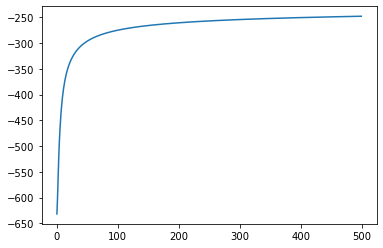

In [67]:
plt.plot(V_1[10,:])
